# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [1]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙️ Step 2: Environment Setup

In [3]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "CartPole-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

seed = 42                  # Random seed to ensure experiment reproducibility

total_timesteps = 40_000   # Number of training steps for Expert PPO (Recommended: 40k for CartPole, 150k for Pendulum, 100k+ for MountainCar)

num_prefs = 500            # Number of preference samples (500 means generating 250 comparisons of expert vs pi2)

sample_length = 500        # Maximum length per trajectory (Recommended: 200 for CartPole and Pendulum, 300–1000 for MountainCar)

# ===========================================================


set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'}")


✅ Environment: CartPole-v1 | Action space: Discrete


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [4]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{seed}.zip")
env.close()


Using cuda device
Wrapping the env in a DummyVecEnv.


/home/menzzz/anaconda3/envs/py38/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | 23.6     |
| time/              |          |
|    fps             | 1456     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | 27.6        |
| time/                   |             |
|    fps                  | 1133        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008758025 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.00345    |
|    learning_rate        | 0.

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [5]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_16000_steps.zip with ~328.9 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [6]:
import numpy as np
import pickle
from tqdm import trange

def generate_trajectory(model, env, max_steps=sample_length):
    obs_list, act_list, rewards = [], [], []
    obs, _ = env.reset()
    for _ in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        obs_list.append(obs)
        act_list.append(action)
        rewards.append(reward)
        obs = obs_
        if done:
            break
    return {"obs": obs_list, "acts": act_list, "rews": rewards}

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
for _ in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(expert_model, env)
    traj2 = generate_trajectory(pi2_model, env)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")




🔄 Generating preference pairs: 100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


✅ Saved 500 preference pairs to prefs_CartPole-v1_seed42.pkl


## 🧱 Step 6: Define Shared Policy Network for DPO and PPO-RLHF

In [8]:
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


## ⚙️ Step 7: Train DPO Policy

In [10]:
def train_dpo(prefs, obs_dim, act_dim, is_discrete, epochs=200, batch_size=16, device='cpu'):
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
    for epoch in range(epochs):
        np.random.shuffle(prefs)
        total_loss = 0
        for i in range(0, len(prefs), batch_size):
            batch = prefs[i:i + batch_size]
            losses = []
            for traj1, traj2, label in batch:
                s1 = torch.tensor(np.stack(traj1['obs']), dtype=torch.float32, device=device)
                s2 = torch.tensor(np.stack(traj2['obs']), dtype=torch.float32, device=device)
                # For discrete action space: convert each action to int
                if is_discrete:
                    a1 = torch.tensor([int(a) for a in traj1['acts']], dtype=torch.long, device=device)
                    a2 = torch.tensor([int(a) for a in traj2['acts']], dtype=torch.long, device=device)
                else:
                    a1 = torch.tensor(np.array(traj1['acts']), dtype=torch.float32, device=device)
                    a2 = torch.tensor(np.array(traj2['acts']), dtype=torch.float32, device=device)

                if is_discrete:
                    logp1 = torch.log_softmax(policy(s1), dim=-1)
                    logp2 = torch.log_softmax(policy(s2), dim=-1)
                    lp1 = logp1[torch.arange(len(a1)), a1].sum()
                    lp2 = logp2[torch.arange(len(a2)), a2].sum()
                else:
                    mu1, std1 = policy(s1)
                    mu2, std2 = policy(s2)
                    dist1 = torch.distributions.Normal(mu1, std1)
                    dist2 = torch.distributions.Normal(mu2, std2)
                    lp1 = dist1.log_prob(a1).sum()
                    lp2 = dist2.log_prob(a2).sum()

                label_tensor = torch.tensor(label, dtype=torch.float32, device=device)
                loss = F.binary_cross_entropy_with_logits((lp1 - lp2).view(1), label_tensor.view(1))
                losses.append(loss)

            batch_loss = torch.stack(losses).mean()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(prefs):.4f}")
    return policy

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:30]

dpo_model = train_dpo(prefs, obs_dim, act_dim, is_discrete)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")


Epoch 1/200, Loss: 9.5472
Epoch 2/200, Loss: 9.4033
Epoch 3/200, Loss: 9.2996
Epoch 4/200, Loss: 9.1772
Epoch 5/200, Loss: 9.1002
Epoch 6/200, Loss: 9.0214
Epoch 7/200, Loss: 8.9396
Epoch 8/200, Loss: 8.7412
Epoch 9/200, Loss: 8.5553
Epoch 10/200, Loss: 8.4046
Epoch 11/200, Loss: 8.1622
Epoch 12/200, Loss: 7.8153
Epoch 13/200, Loss: 7.6570
Epoch 14/200, Loss: 7.2860
Epoch 15/200, Loss: 6.8742
Epoch 16/200, Loss: 6.4185
Epoch 17/200, Loss: 6.0251
Epoch 18/200, Loss: 5.5222
Epoch 19/200, Loss: 5.0445
Epoch 20/200, Loss: 4.4336
Epoch 21/200, Loss: 4.1711
Epoch 22/200, Loss: 3.8643
Epoch 23/200, Loss: 3.5570
Epoch 24/200, Loss: 3.3434
Epoch 25/200, Loss: 3.1028
Epoch 26/200, Loss: 3.0134
Epoch 27/200, Loss: 2.9242
Epoch 28/200, Loss: 2.7382
Epoch 29/200, Loss: 2.8001
Epoch 30/200, Loss: 2.6254
Epoch 31/200, Loss: 2.6202
Epoch 32/200, Loss: 2.6004
Epoch 33/200, Loss: 2.4955
Epoch 34/200, Loss: 2.4873
Epoch 35/200, Loss: 2.5006
Epoch 36/200, Loss: 2.2819
Epoch 37/200, Loss: 2.3468
Epoch 38/2

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [11]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(prefs, obs_dim, act_dim, is_discrete, epochs=200, batch_size=16, lr=1e-3, device='cpu'):
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(epochs):
        np.random.shuffle(prefs)
        total_loss = 0.0
        for i in range(0, len(prefs), batch_size):
            batch = prefs[i:i + batch_size]
            losses = []
            for traj1, traj2, label in batch:
                s1 = torch.tensor(np.stack(traj1['obs']), dtype=torch.float32, device=device)
                s2 = torch.tensor(np.stack(traj2['obs']), dtype=torch.float32, device=device)
                if is_discrete:
                    a1 = torch.tensor([int(a) for a in traj1['acts']], dtype=torch.long, device=device)
                    a2 = torch.tensor([int(a) for a in traj2['acts']], dtype=torch.long, device=device)
                else:
                    a1 = torch.tensor(np.stack(traj1['acts']), dtype=torch.float32, device=device)
                    a2 = torch.tensor(np.stack(traj2['acts']), dtype=torch.float32, device=device)
                r1 = model(s1, a1).sum()
                r2 = model(s2, a2).sum()
                y = torch.tensor(label, dtype=torch.float32, device=device)
                loss = criterion((r1 - r2).view(1), y.view(1))
                losses.append(loss)
            batch_loss = torch.stack(losses).mean()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(prefs):.4f}")
    return model

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:30]

reward_model = train_reward_model(prefs, obs_dim, act_dim, is_discrete)
torch.save(reward_model.state_dict(), f"{env_id}_reward_model_{env_id}_seed{seed}.pth")


Epoch 1/200, Loss: 0.0991
Epoch 2/200, Loss: 0.0152
Epoch 3/200, Loss: 0.0020
Epoch 4/200, Loss: 0.0004
Epoch 5/200, Loss: 0.0002
Epoch 6/200, Loss: 0.0001
Epoch 7/200, Loss: 0.0000
Epoch 8/200, Loss: 0.0000
Epoch 9/200, Loss: 0.0000
Epoch 10/200, Loss: 0.0000
Epoch 11/200, Loss: 0.0000
Epoch 12/200, Loss: 0.0000
Epoch 13/200, Loss: 0.0000
Epoch 14/200, Loss: 0.0000
Epoch 15/200, Loss: 0.0000
Epoch 16/200, Loss: 0.0000
Epoch 17/200, Loss: 0.0000
Epoch 18/200, Loss: 0.0000
Epoch 19/200, Loss: 0.0000
Epoch 20/200, Loss: 0.0000
Epoch 21/200, Loss: 0.0000
Epoch 22/200, Loss: 0.0000
Epoch 23/200, Loss: 0.0000
Epoch 24/200, Loss: 0.0000
Epoch 25/200, Loss: 0.0000
Epoch 26/200, Loss: 0.0000
Epoch 27/200, Loss: 0.0000
Epoch 28/200, Loss: 0.0000
Epoch 29/200, Loss: 0.0000
Epoch 30/200, Loss: 0.0000
Epoch 31/200, Loss: 0.0000
Epoch 32/200, Loss: 0.0000
Epoch 33/200, Loss: 0.0000
Epoch 34/200, Loss: 0.0000
Epoch 35/200, Loss: 0.0000
Epoch 36/200, Loss: 0.0000
Epoch 37/200, Loss: 0.0000
Epoch 38/2

## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [12]:
import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# Wrap the environment with the trained reward_net
reward_model.eval()  # Ensure the model is in inference mode
env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
env = Monitor(env)

# Retrain the policy using the new reward
rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
rlhf_model.learn(total_timesteps=400000)
rlhf_model.save(f"{env_id}_rlhf_seed{seed}.zip")


Using cuda device
Wrapping the env in a DummyVecEnv.


/home/menzzz/anaconda3/envs/py38/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | 2.81     |
| time/              |          |
|    fps             | 1417     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.8        |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 1110        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014504612 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.0334     |
|    learning_rate        | 0.

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/tmp/ipykernel_76363/2389077344.py:30: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/menzzz/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


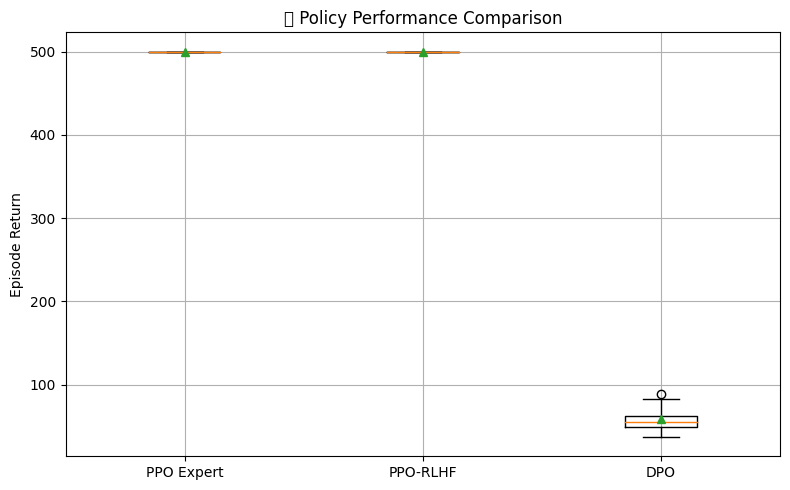

In [13]:
def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for _ in range(episodes):
        obs, _ = env.reset()
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns


env = gym.make(env_id)
returns_expert = eval_policy(PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env), env)
returns_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env), env)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
returns_dpo    = eval_policy(dpo_model, env, is_sb3=False)

plt.figure(figsize=(8, 5))
plt.boxplot([returns_expert, returns_rlhf, returns_dpo],
            labels=["PPO Expert", "PPO-RLHF", "DPO"],
            showmeans=True)
plt.title("🎯 Policy Performance Comparison")
plt.ylabel("Episode Return")
plt.grid(True)
plt.tight_layout()
plt.show()



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/menzzz/anaconda3/envs/py38/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


✅ GIF saved to: /home/menzzz/2024/learning/RL/EE-568-RL/CartPole-v1_comparison_seed42.gif


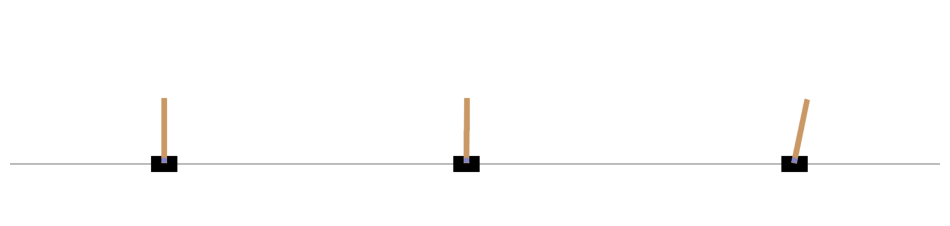

In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: Run a single episode and record rendered frames
def record_episode(model, env, is_sb3=True, max_steps=1000):
    frames = []
    obs, _ = env.reset()
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: Combine multiple frame sequences into a single animation and optionally save as a GIF
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

# Step 3: Load models and environments
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_dpo    = gym.make(env_id, render_mode="rgb_array")

expert_model = PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env_rlhf)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))

# Step 4: Collect animation frames for all three strategies
frames_expert = record_episode(expert_model, env_expert)
frames_rlhf   = record_episode(rlhf_model, env_rlhf)
frames_dpo    = record_episode(dpo_model, env_dpo, is_sb3=False)

# Step 5: Display the combined animation and save it as a GIF file
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO</h3>"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_dpo],
    gif_path=f"{env_id}_comparison_seed{seed}.gif"
))
